# 1. Observations on 1 pixel kernel

In Line (I), the operation ```self.in2out = nn.Conv2d(in_ch, out_ch, 1)``` is used to change the number of channels from in_ch to out_ch. By using a 1×1 kernel, this convolution applies a transformation independently to each pixel across channels. Instead of considering neighboring pixels, it performs a per-pixel operation, essentially appling learned linear transformation to each pixel's channel values. This allows for a channel-wise transformation while preserving spatial structure.

In Lines (K) and (L), the operations ```self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)``` and ```self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)``` serve as downsamplers. By setting stride=2, the convolution layer skips every other pixel in both the width and height dimensions. This results in a reduction of spatial resolution while performing a per-pixel linear transformation across channels. Unlike conventional convolution, which considers spatial neighbors, this method reduces the number of pixels processed while retaining key features.

The reason why Lines (I), (K), and (L) make sense in using a 1×1 kernel is that they perform a linear transformation at each pixel location while maintaining spatial information. Line (I) adjusts the number of channels without altering spatial dimensions, whereas Lines (K) and (L) downsample the feature map while preserving channel-wise structure. 


# 2. BMENet with maxpool

In [ ]:
import os, sys
print(os.getcwd())
sys.path.append("./../DLStudio-2.5.1")

# from DLStudio import *

d:\MS Purdue\1.5\ECE60146\HW6


In [15]:
from DLStudio import DLStudio
import torch
import torch.nn as nn

class BMEnetModifiedForMaxpool(DLStudio.BMEnet):
    def __init__(self, dl_studio, skip_connections=True, depth=8, use_maxpool=True):
        # init the parent class, same as parent's constructor!
        super().__init__(dl_studio, skip_connections, depth)

        # now we can modify the constructor to add maxpool layers
        self.use_maxpool = use_maxpool

        # borrow from the DLStudio.py
        self.dl_studio = dl_studio
        self.depth = depth
        image_size = dl_studio.image_size
        num_ds = 0          
        self.conv = nn.Conv2d(3, 64, 3, padding=1)
        self.skip64_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip64_arr.append(self.SkipBlock(64, 64, skip_connections=skip_connections, use_maxpool=use_maxpool))
        self.skip64to128ds = self.SkipBlock(64, 128, downsample=True, skip_connections=skip_connections, use_maxpool=use_maxpool )
        num_ds += 1              
        self.skip128_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip128_arr.append(self.SkipBlock(128, 128, skip_connections=skip_connections, use_maxpool=use_maxpool))
        self.skip128to256ds = self.SkipBlock(128, 256, downsample=True, skip_connections=skip_connections, use_maxpool=use_maxpool )
        num_ds += 1
        self.skip256_arr = nn.ModuleList()
        for i in range(self.depth):
            self.skip256_arr.append(self.SkipBlock(256, 256, skip_connections=skip_connections, use_maxpool=use_maxpool))
        self.fc1 =  nn.Linear( (image_size[0]// (2 ** num_ds))  *  (image_size[1]//(2 ** num_ds))  * 256, 1000)
        self.fc2 =  nn.Linear(1000, 10)


    class SkipBlock(nn.Module):
            """
            Class Path:   DLStudio  ->  BMEnet  ->  SkipBlock
            """            
            def __init__(self, in_ch, out_ch, downsample=False, skip_connections=True, use_maxpool=True):
                super().__init__()
                self.downsample = downsample
                self.skip_connections = skip_connections
                self.use_maxpool = use_maxpool
                self.in_ch = in_ch
                self.out_ch = out_ch
                self.convo1 = nn.Conv2d(in_ch, in_ch, 3, stride=1, padding=1)
                self.convo2 = nn.Conv2d(in_ch, out_ch, 3, stride=1, padding=1)
                self.bn1 = nn.BatchNorm2d(in_ch)
                self.bn2 = nn.BatchNorm2d(out_ch)
                self.in2out  =  nn.Conv2d(in_ch, out_ch, 1)       
                if downsample:
                    ##  Setting stride to 2 and kernel_size to 1 amounts to retaining every
                    ##  other pixel in the image --- which halves the size of the image:
                    # self.downsampler1 = nn.Conv2d(in_ch, in_ch, 1, stride=2)
                    # self.downsampler2 = nn.Conv2d(out_ch, out_ch, 1, stride=2)

                    # change the downsampler to maxpool
                    self.downsampler1 = nn.MaxPool2d(2, 2)
                    self.downsampler2 = nn.MaxPool2d(2, 2)

            def forward(self, x):
                identity = x   # identity holds the original input tensor to the skip block                                  
                out = self.convo1(x)                              
                out = self.bn1(out)                              
                out = nn.functional.relu(out)
                out = self.convo2(out)                              
                out = self.bn2(out)                              
                out = nn.functional.relu(out)
                if self.downsample:
                    identity = self.downsampler1(identity)
                    out = self.downsampler2(out)
                if self.skip_connections:
                    if (self.in_ch == self.out_ch) and (self.downsample is False):
                        out = out + identity
                    elif (self.in_ch != self.out_ch) and (self.downsample is False):
                        identity = self.in2out( identity )     
                        out = out + identity
                    elif (self.in_ch != self.out_ch) and (self.downsample is True):
                        # concatenates the identity tensor with itself along the channel dimension
                        out = out + torch.cat((identity, identity), dim=1) # e.g. If the original identity has shape (B, in_ch, H, W), after concatenation it becomes (B, 2 * in_ch, H, W).
                return out
            


dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-4,
                epochs = 6,
                batch_size = 4,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = BMEnetModifiedForMaxpool(dls, skip_connections=True, depth=8, use_maxpool=True)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)

Files already downloaded and verified
Files already downloaded and verified


The number of learnable parameters in the model: 30092354


Starting training loop...



[epoch:1/6  iter=1000  elapsed_time=   56 secs]   Ground Truth:           ship       frog        car        cat
[epoch:1/6  iter=1000  elapsed_time=   56 secs]   Predicted Labels:        cat        cat        cat        cat
[epoch:1/6  iter=1000  elapsed_time=   56 secs]   Loss: 2.686


[epoch:1/6  iter=2000  elapsed_time=  108 secs]   Ground Truth:            cat       frog       frog      horse
[epoch:1/6  iter=2000  elapsed_time=  108 secs]   Predicted Labels:       bird       bird       bird       bird
[epoch:1/6  iter=2000  elapsed_time=  108 secs]   Loss: 2.304


[epoch:1/6  iter=3000  elapsed_time=  165 secs]   Ground Truth:          horse      plane        dog       deer
[epoch:1/6  iter=3000  elapsed_time=  165 secs]   Predicted Labels:      horse      horse      horse      horse
[epoch:1/6  iter=3000  elapsed_ti

KeyboardInterrupt: 

### 2.1 Train loss curve

### 2.2 Confusion Matrix

# 3. BMENet with stride

ter=3000  elapsed_time=   93 secs]   Loss: 1.641


[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Ground Truth:          horse      plane       ship        dog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Predicted Labels:       ship      plane       ship       frog
[epoch:1/6  iter=4000  elapsed_time=  122 secs]   Loss: 1.556


[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Ground Truth:          plane       bird      plane        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Predicted Labels:      plane       frog        dog        car
[epoch:1/6  iter=5000  elapsed_time=  151 secs]   Loss: 1.478


[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Ground Truth:          plane       ship       deer        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Predicted Labels:       bird       ship        dog        cat
[epoch:1/6  iter=6000  elapsed_time=  181 secs]   Loss: 1.384


[epoch:1/6  iter=7000  elapsed_time=  210 secs]   Ground Truth:           ship      h

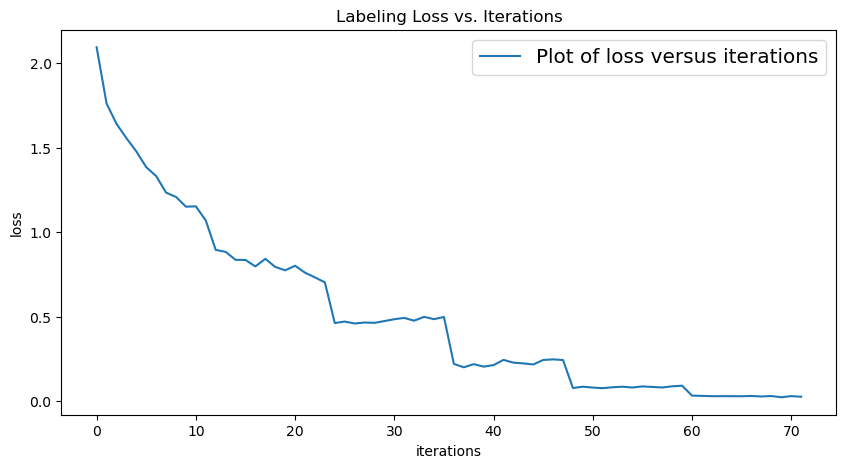

/home/chen4126/ece60146/HW6/./../DLStudio-2.5.1/DLStudio/DLStudio.py:2964: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load(self.path_saved_model

In [3]:
dls = DLStudio(
#                  dataroot = "/home/kak/ImageDatasets/CIFAR-10/",
                dataroot = "./../data/CIFAR-10/",
                image_size = [32,32],
                path_saved_model = "./saved_model",
                momentum = 0.9,
                learning_rate = 1e-4,
                epochs = 6,
                batch_size = 4,
                classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck'),
                use_gpu = True,
            )

bme_net = dls.BMEnet(dls, skip_connections=True, depth=8)         ## if you want to use skips

bme_net.load_cifar_10_dataset()

## display network properties
number_of_learnable_params = sum(p.numel() for p in bme_net.parameters() if p.requires_grad)
print("\n\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)

## training and testing
bme_net.run_code_for_training(bme_net, display_images=False)
bme_net.run_code_for_testing(bme_net, display_images=False)


### 3.1 Train loss curve
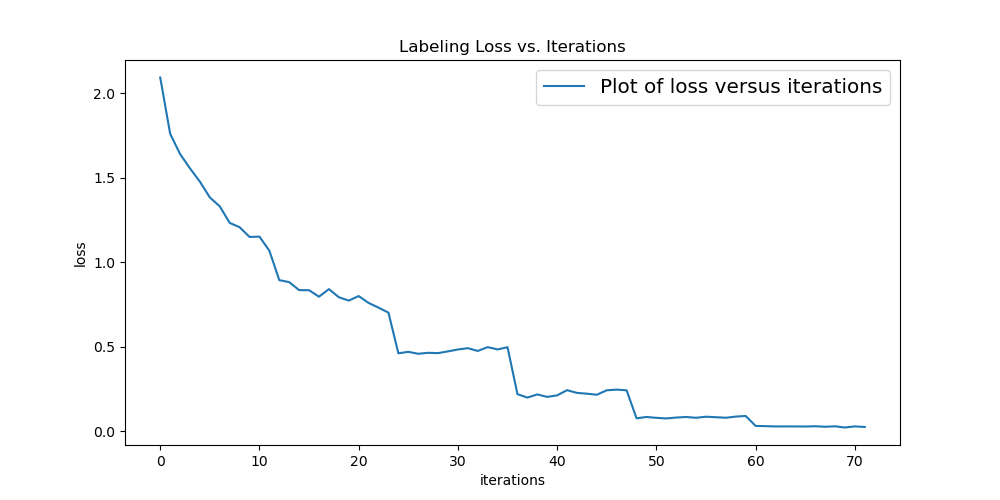

### 3.2 Confusion Matrix
|        | Plane  | Car   | Bird  | Cat   | Deer  | Dog   | Frog  | Horse | Ship  | Truck |
|--------|--------|-------|-------|-------|-------|-------|-------|-------|-------|-------|
| **Plane** | 78.10  | 1.60  | 7.50  | 2.30  | 0.70  | 0.50  | 1.20  | 0.50  | 4.60  | 3.00  |
| **Car**   | 0.30  | 93.20 | 0.10  | 0.60  | 0.00  | 0.10  | 1.00  | 0.10  | 1.40  | 3.20  |
| **Bird**  | 3.60  | 0.60  | 73.90 | 6.20  | 4.40  | 4.20  | 3.90  | 1.30  | 1.00  | 0.90  |
| **Cat**   | 1.00  | 0.70  | 6.10  | 67.60 | 3.10  | 12.00 | 5.40  | 2.30  | 1.20  | 0.60  |
| **Deer**  | 1.30  | 0.60  | 8.10  | 6.80  | 71.30 | 2.30  | 4.80  | 4.40  | 0.40  | 0.00  |
| **Dog**   | 0.90  | 0.20  | 4.00  | 18.70 | 1.50  | 68.20 | 2.20  | 3.50  | 0.40  | 0.40  |
| **Frog**  | 0.40  | 0.60  | 3.70  | 5.70  | 1.20  | 1.00  | 86.70 | 0.10  | 0.40  | 0.20  |
| **Horse** | 1.40  | 0.10  | 2.60  | 5.20  | 2.80  | 3.60  | 0.60  | 82.60 | 0.20  | 0.90  |
| **Ship**  | 3.50  | 3.40  | 1.30  | 1.10  | 0.30  | 0.50  | 0.70  | 0.10  | 87.50 | 1.60  |
| **Truck** | 2.00  | 7.30  | 0.80  | 2.10  | 0.30  | 0.40  | 0.60  | 0.80  | 1.50  | 84.20 |


# 4. Table1: Overall accuracy of 2 models table
|   | Maxpool | Stride|
|---|---------|-------|
| Accuracy| %| 79%|

# 5. Table2: Per class accuracy of 2 models (10x2 table)
|        | Maxpool  | Stride   | 
|--------|--------|-------|
| **Plane** |   | 78  | 
| **Car**   |   | 93 | 
| **Bird**  |   | 73  | 
| **Cat**   |   | 67  | 
| **Deer**  |   | 71  | 
| **Dog**   |   | 68  | 
| **Frog**  |   | 86  |
| **Horse** |   | 82  | 
| **Ship**  |   | 87  | 
| **Truck** |   | 84  | 

# 6. Observations of Maxpool vs Stride

# 7. Skip Connections with MSCOCO

### 7.1 5x3 images

### 7.2 train loss curve

### 7.3 conf matrix 5x5

### 7.4 overall accuracy

### 7.5 per class accuracy 5x1 table

### 7.6 observations